# Notebook for the Kings County Data Set
Author: Eike Rogall

In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import seaborn as sns
import plotly
import plotly.express as px
import math
import plotly.graph_objects as go

import statsmodels.api as sms
import statsmodels.formula.api as smf


from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

sns.set(style="whitegrid")
matplotlib.style.use('seaborn')
%matplotlib inline

 ## Column Names and descriptions for Kings County Data Set
- **id** - Unique ID for each home sold

- **date** - Date of the home sale

- **price** - Price of each home sold

- **bedrooms** - Number of bedrooms

- **bathrooms** - Number of bathrooms, where .5 accounts for a room with a toilet but no shower

- **sqft_living** - Square footage of the apartments interior living space

- **sqft_lot** - Square footage of the land space

- **floors** - Number of floors

- **waterfront** - A dummy variable for whether the apartment was overlooking the waterfront or not

- **view** - An index from 0 to 4 of how good the view of the property was

- **condition** - An index from 1 to 5 on the condition of the apartment,1 - lowest, 5 - highest

- **grade** - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.

- **sqft_above** - The square footage of the interior housing space that is above ground level

- **sqft_basement** - The square footage of the interior housing space that is below ground level

- **yr_built** - The year the house was initially built

- **yr_renovated** - The year of the house’s last renovation

- **zipcode** - What zipcode area the house is in

- **lat** - Lattitude

- **long** - Longitude

- **sqft_living15** - The square footage of interior housing living space for the nearest 15 neighbors

- **sqft_lot15** - The square footage of the land lots of the nearest 15 neighbors

### Added columns
- **log_price**: log of the price because the logarithmic price scales tend to show less severe price increases or decreases than linear price scales.
- **sqft_basement_new**: remove the missing of sqft_basement values by sqft_living-sqft_above
- **sqft_total**: Total square footage of the real estate
- **sqft_total15**: Total square footage of the real estate for the nearest 15 neighbors
- **month**: Month of home sale
- **year**: year of home sale
- **rating_grade_condition**: A new rating system for the houses (product of grade * condition)
- **living_ratio**: Ratio between sqft_living15 and sqft_living
- **lot_ratio**: Ratio between sqft_lot15 and sqft_lot


The first question I asked myself was: How expensive is a house for a standard four person house hold, are there any bargains and where is the cheapest house with the optimal features.

**HOW ARE TOTAL & TOTAL LIVING USED?** <br>
You use the Total Living square feet when you are considering what it will be like to live in the house. It can also be used to calculate the square feet needed depending on the number of people in the home.

Generally, the **number of people** that will be in the house should be **multiplied by 550 sq. ft.** For example a family of 4 should be looking at homes no smaller than 2200 sq. ft. Of course this is just a rough guide, but it can be a helpful tool.

The Total Square Feet is arguably more important. This number will be used by your builder to help calculate the estimated building cost. In some cases it might also be used to see if a house plan meets the requirements of local building codes or guide-lines.

If you give a builder the Living square feet number to use in his estimate calculations, the costs will be all wrong. So it is very important that these two numbers are clearly understood. <br>
Source: https://saterdesign.com/blogs/news/living-area-explained

The second question was, can I get from the same features I looked for the family of four, results for investment oportunities.

Data Science Lifecycle
- 1 Business Understanding
- 2 Data Mining
- 3 Data Cleaning
- 4 Data Exploration
- 5 Feature Engineering
- 6 Predictive Modeling
- 7 Data Visualization

In [2]:
house_prices = pd.read_csv('King_County_House_prices_dataset.csv')

## Data cleaning - Type of data and missings

In [3]:
house_prices.head(10)

id        date      price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014   221900.0         3       1.00         1180   
1  6414100192   12/9/2014   538000.0         3       2.25         2570   
2  5631500400   2/25/2015   180000.0         2       1.00          770   
3  2487200875   12/9/2014   604000.0         4       3.00         1960   
4  1954400510   2/18/2015   510000.0         3       2.00         1680   
5  7237550310   5/12/2014  1230000.0         4       4.50         5420   
6  1321400060   6/27/2014   257500.0         3       2.25         1715   
7  2008000270   1/15/2015   291850.0         3       1.50         1060   
8  2414600126   4/15/2015   229500.0         3       1.00         1780   
9  3793500160   3/12/2015   323000.0         3       2.50         1890   

   sqft_lot  floors  waterfront  view  ...  grade  sqft_above  sqft_basement  \
0      5650     1.0         NaN   0.0  ...      7        1180            0.0   
1      7242     2.0         0.0   0.0  ...      7        2170          400.0   
2     10000     1.0         0.0   0.0  ...      6         770            0.0   
3      5000     1.0         0.0   0.0  ...      7        1050          910.0   
4      8080     1.0         0.0   0.0  ...      8        1680            0.0   
5    101930     1.0         0.0   0.0  ...     11        3890         1530.0   
6      6819     2.0         0.0   0.0  ...      7        1715              ?   
7      9711     1.0         0.0   NaN  ...      7        1060            0.0   
8      7470     1.0         0.0   0.0  ...      7        1050          730.0   
9      6560     2.0         0.0   0.0  ...      7        1890            0.0   

  yr_built  yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  
0     1955           0.0    98178  47.5112 -122.257           1340        5650  
1     1951        1991.0    98125  47.7210 -122.319           1690        7639  
2     1933           NaN    98028  47.7379 -122.233           2720        8062  
3     1965           0.0    98136  47.5208 -122.393           1360        5000  
4     1987           0.0    98074  47.6168 -122.045           1800        7503  
5     2001           0.0    98053  47.6561 -122.005           4760      101930  
6     1995           0.0    98003  47.3097 -122.327           2238        6819  
7     1963           0.0    98198  47.4095 -122.315           1650        9711  
8     1960           0.0    98146  47.5123 -122.337           1780        8113  
9     2003           0.0    98038  47.3684 -122.031           2390        7570  

[10 rows x 21 columns]

In [4]:
house_prices.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
id               21597 non-null int64
date             21597 non-null object
price            21597 non-null float64
bedrooms         21597 non-null int64
bathrooms        21597 non-null float64
sqft_living      21597 non-null int64
sqft_lot         21597 non-null int64
floors           21597 non-null float64
waterfront       19221 non-null float64
view             21534 non-null float64
condition        21597 non-null int64
grade            21597 non-null int64
sqft_above       21597 non-null int64
sqft_basement    21597 non-null object
yr_built         21597 non-null int64
yr_renovated     17755 non-null float64
zipcode          21597 non-null int64
lat              21597 non-null float64
long             21597 non-null float64
sqft_living15    21597 non-null int64
sqft_lot15       21597 non-null int64
dtypes: float64(8), int64(11), object(2)
memory usage: 3.5+ MB


To replace the questionmarks in the sqft_basement columns with NaNs and get  the right datatype the following steps were conducted:

In [5]:
house_prices[house_prices['sqft_basement'] == '?'].shape[0]

454

In [6]:
house_prices['sqft_basement'] = house_prices['sqft_basement'].replace('?', np.NaN)
house_prices['sqft_basement'] = house_prices['sqft_basement'].astype(float)

In [7]:
house_prices.eval('sqft_basement_new = sqft_living - sqft_above', inplace=True)
house_prices.drop('sqft_basement', axis=1, inplace=True)

The missing values of all variables were counted:

In [8]:
missing_values = pd.DataFrame(house_prices.isnull().sum(),columns=['count'])
missing_values['percentage'] = missing_values['count']/house_prices.shape[0]*100
missing_values.query('count != 0')

count  percentage
waterfront     2376   11.001528
view             63    0.291707
yr_renovated   3842   17.789508

**Of the 21 variables 3 have missing values.**

- **waterfront** has 2376 missing values (11 %)
- **view** has 63 missing values (0.29 %)
- **yr_renovated** has 3842 missing values (17,79 %)
- **sqft_basement** had 454 missing values (2,10 %), but was replaced with sqft_basement_new



The column 'view' has only 0,29 % missing values and has 19422 times of 21597 the value 0, so i decided to replace the missing values with 0.

In [9]:
house_prices['view'].value_counts()

0.0    19422
2.0      957
3.0      508
1.0      330
4.0      317
Name: view, dtype: int64

In [10]:
house_prices['view'].fillna(0, inplace=True)

In [11]:
missing_values = pd.DataFrame(house_prices.isnull().sum(),columns=['count'])
missing_values['percentage'] = missing_values['count']/house_prices.shape[0]*100
missing_values.query('count != 0')

count  percentage
waterfront     2376   11.001528
yr_renovated   3842   17.789508

## Data Exploration 
### Basic Statistic

In [12]:
house_prices.describe().round(2)

id       price  bedrooms  bathrooms  sqft_living    sqft_lot  \
count  2.159700e+04    21597.00  21597.00   21597.00     21597.00    21597.00   
mean   4.580474e+09   540296.57      3.37       2.12      2080.32    15099.41   
std    2.876736e+09   367368.14      0.93       0.77       918.11    41412.64   
min    1.000102e+06    78000.00      1.00       0.50       370.00      520.00   
25%    2.123049e+09   322000.00      3.00       1.75      1430.00     5040.00   
50%    3.904930e+09   450000.00      3.00       2.25      1910.00     7618.00   
75%    7.308900e+09   645000.00      4.00       2.50      2550.00    10685.00   
max    9.900000e+09  7700000.00     33.00       8.00     13540.00  1651359.00   

         floors  waterfront      view  condition     grade  sqft_above  \
count  21597.00    19221.00  21597.00   21597.00  21597.00    21597.00   
mean       1.49        0.01      0.23       3.41      7.66     1788.60   
std        0.54        0.09      0.76       0.65      1.17      827.76   
min        1.00        0.00      0.00       1.00      3.00      370.00   
25%        1.00        0.00      0.00       3.00      7.00     1190.00   
50%        1.50        0.00      0.00       3.00      7.00     1560.00   
75%        2.00        0.00      0.00       4.00      8.00     2210.00   
max        3.50        1.00      4.00       5.00     13.00     9410.00   

       yr_built  yr_renovated   zipcode       lat      long  sqft_living15  \
count  21597.00      17755.00  21597.00  21597.00  21597.00       21597.00   
mean    1971.00         83.64  98077.95     47.56   -122.21        1986.62   
std       29.38        399.95     53.51      0.14      0.14         685.23   
min     1900.00          0.00  98001.00     47.16   -122.52         399.00   
25%     1951.00          0.00  98033.00     47.47   -122.33        1490.00   
50%     1975.00          0.00  98065.00     47.57   -122.23        1840.00   
75%     1997.00          0.00  98118.00     47.68   -122.12        2360.00   
max     2015.00       2015.00  98199.00     47.78   -121.32        6210.00   

       sqft_lot15  sqft_basement_new  
count    21597.00           21597.00  
mean     12758.28             291.73  
std      27274.44             442.67  
min        651.00               0.00  
25%       5100.00               0.00  
50%       7620.00               0.00  
75%      10083.00             560.00  
max     871200.00            4820.00

33 bedrooms seems to be a quite high number, additionally the bedroom/bathroom ratio 33/1.75 seems odd too so I will remove this house:

In [13]:
house_prices.query('bedrooms == 33')

id       date     price  bedrooms  bathrooms  sqft_living  \
15856  2402100895  6/25/2014  640000.0        33       1.75         1620   

       sqft_lot  floors  waterfront  view  ...  grade  sqft_above  yr_built  \
15856      6000     1.0         0.0   0.0  ...      7        1040      1947   

       yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  \
15856           0.0    98103  47.6878 -122.331           1330        4700   

       sqft_basement_new  
15856                580  

[1 rows x 21 columns]

In [14]:
house_prices.drop(15856, axis=0, inplace=True)

In [15]:
print(len(house_prices['zipcode'].unique()))
house_prices['zipcode'].unique()

70


array([98178, 98125, 98028, 98136, 98074, 98053, 98003, 98198, 98146,
       98038, 98007, 98115, 98107, 98126, 98019, 98103, 98002, 98133,
       98040, 98092, 98030, 98119, 98112, 98052, 98027, 98117, 98058,
       98001, 98056, 98166, 98023, 98070, 98148, 98105, 98042, 98008,
       98059, 98122, 98144, 98004, 98005, 98034, 98075, 98116, 98010,
       98118, 98199, 98032, 98045, 98102, 98077, 98108, 98168, 98177,
       98065, 98029, 98006, 98109, 98022, 98033, 98155, 98024, 98011,
       98031, 98106, 98072, 98188, 98014, 98055, 98039])

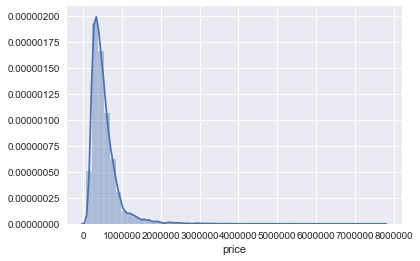

In [16]:
x = house_prices.price
sns.distplot(x);

**Logarithmic price scales tend to show less severe price increases or decreases than linear price scales.**

In [17]:
house_prices['log_price'] = [math.log(element) for element in house_prices['price']]
house_prices.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  sqft_above  yr_built  \
0      5650     1.0         NaN   0.0  ...        1180      1955   
1      7242     2.0         0.0   0.0  ...        2170      1951   
2     10000     1.0         0.0   0.0  ...         770      1933   
3      5000     1.0         0.0   0.0  ...        1050      1965   
4      8080     1.0         0.0   0.0  ...        1680      1987   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  \
0           0.0    98178  47.5112 -122.257           1340        5650   
1        1991.0    98125  47.7210 -122.319           1690        7639   
2           NaN    98028  47.7379 -122.233           2720        8062   
3           0.0    98136  47.5208 -122.393           1360        5000   
4           0.0    98074  47.6168 -122.045           1800        7503   

   sqft_basement_new  log_price  
0                  0  12.309982  
1                400  13.195614  
2                  0  12.100712  
3                910  13.311329  
4                  0  13.142166  

[5 rows x 22 columns]

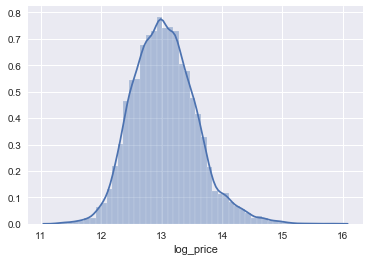

In [18]:
x = house_prices.log_price
sns.distplot(x);

### Correlation

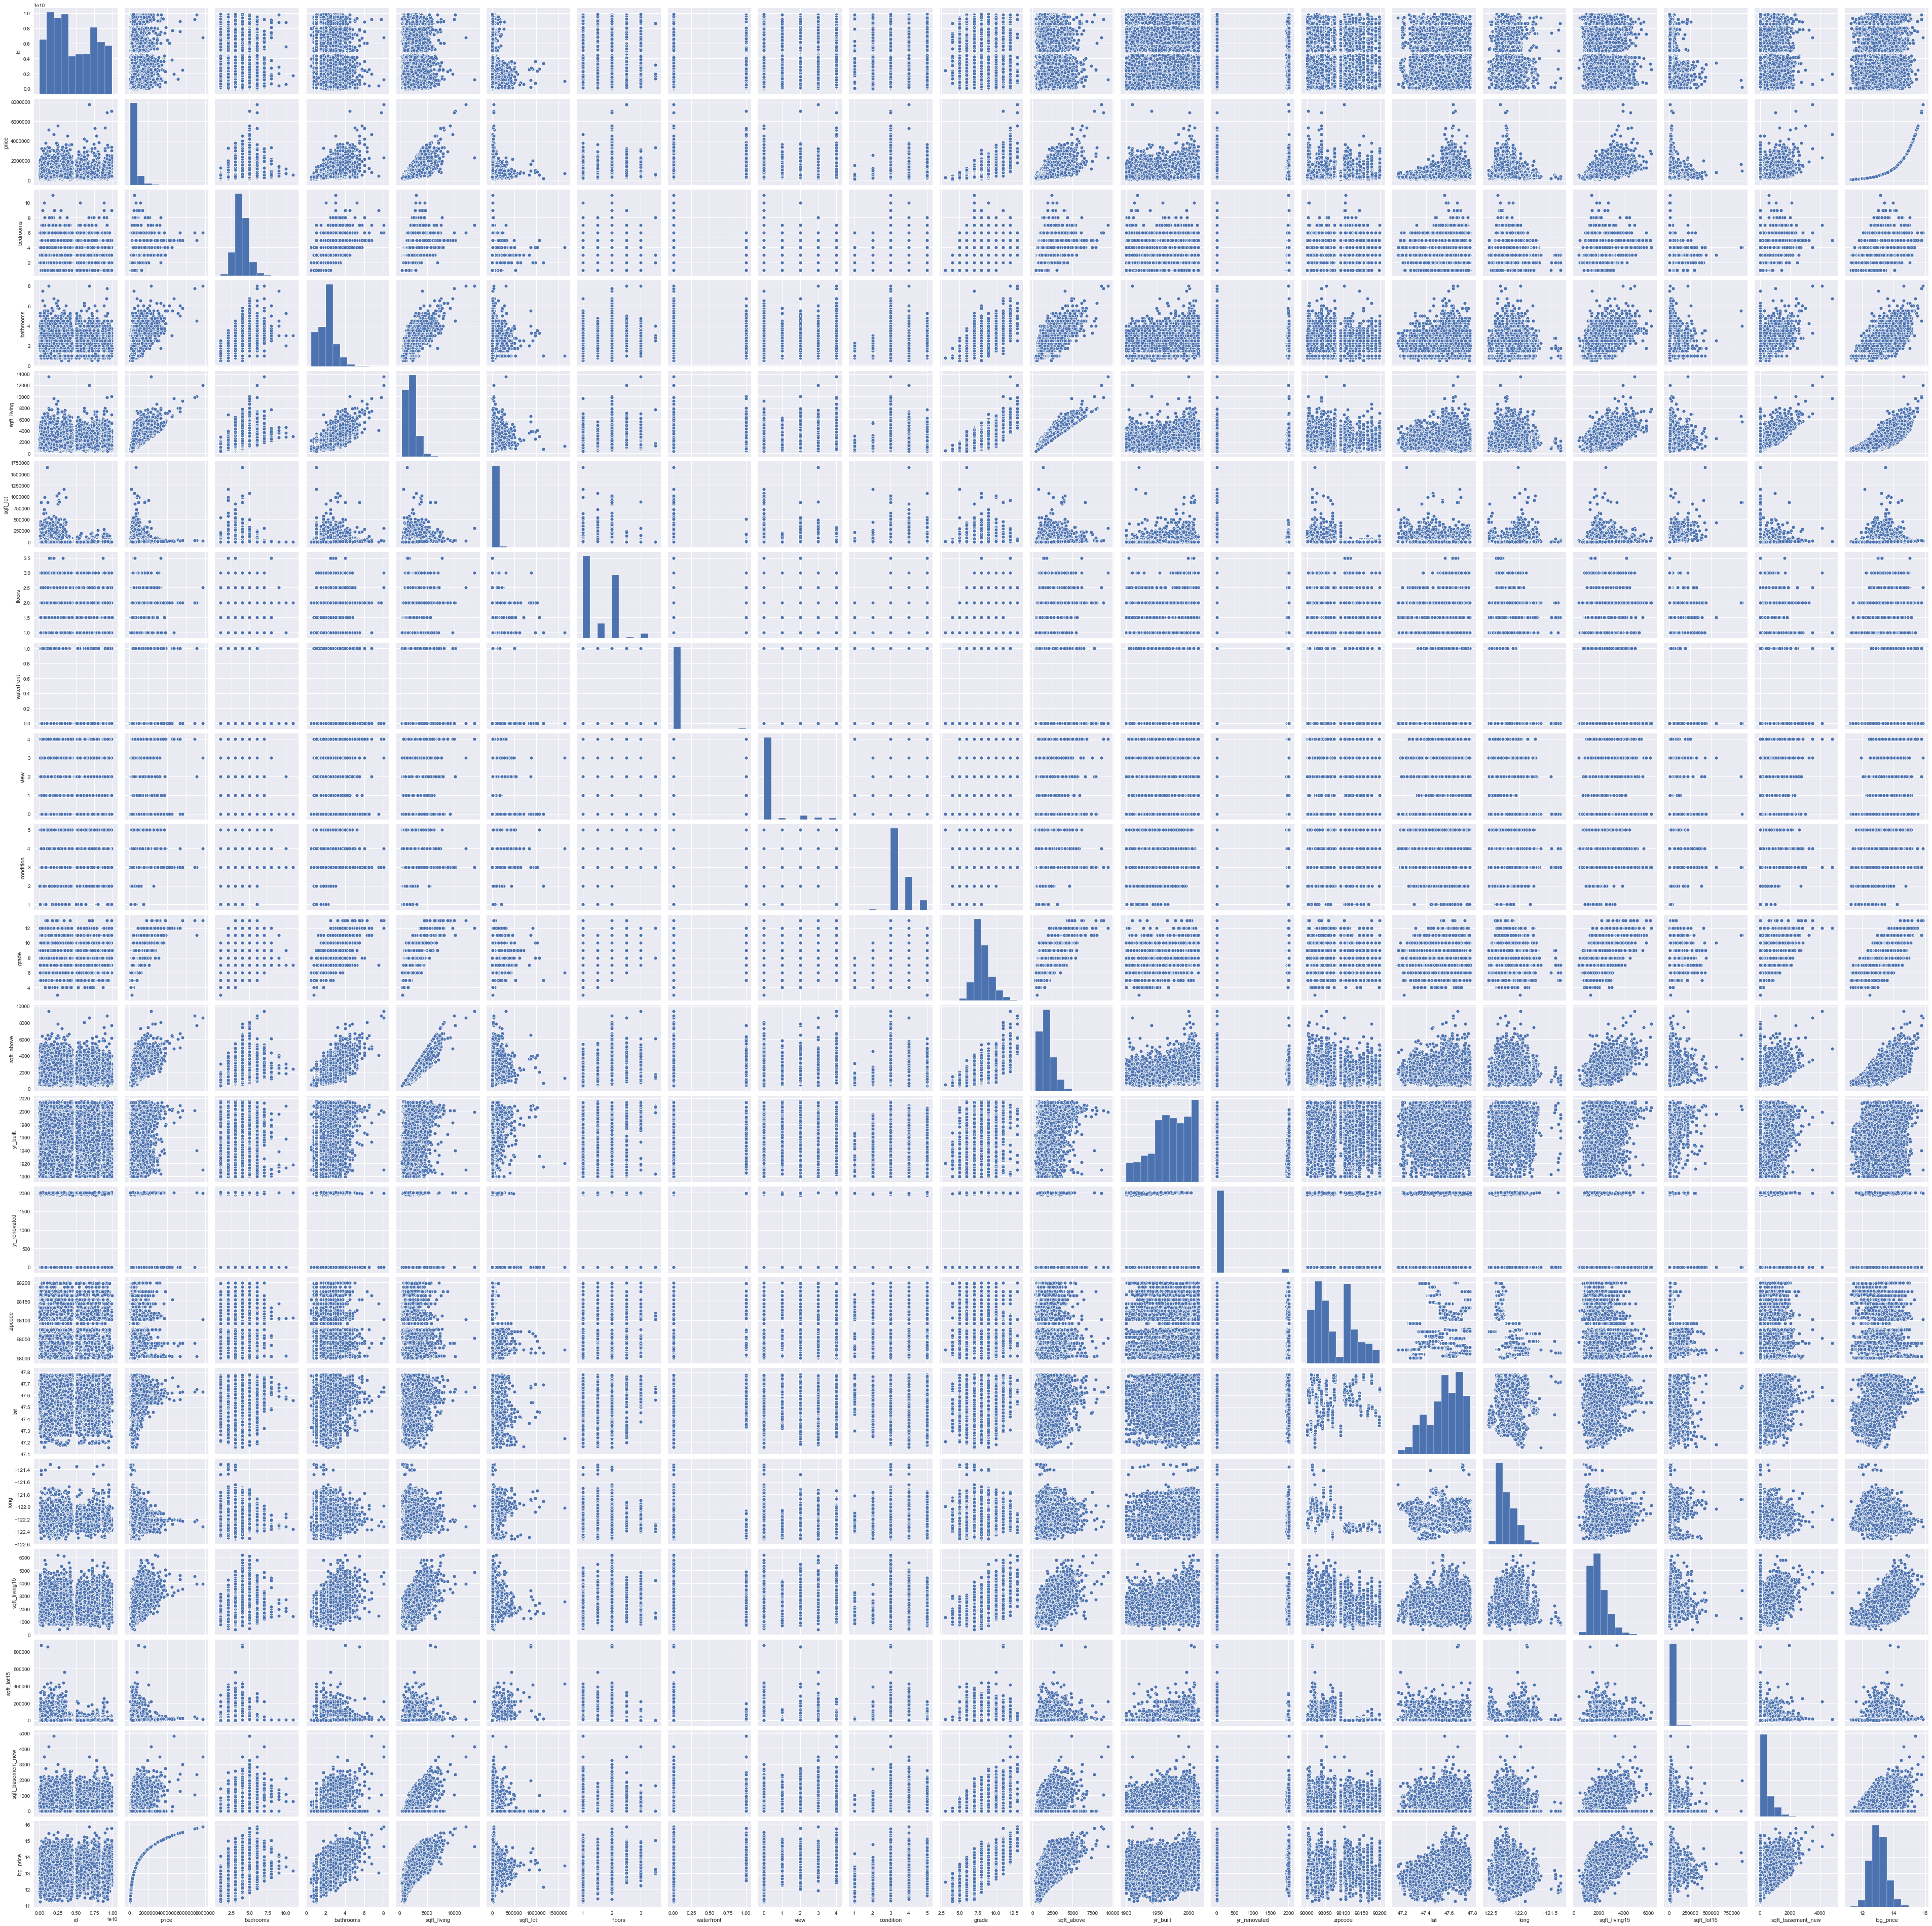

In [19]:
sns.pairplot(house_prices)

In [20]:
house_prices.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  sqft_above  yr_built  \
0      5650     1.0         NaN   0.0  ...        1180      1955   
1      7242     2.0         0.0   0.0  ...        2170      1951   
2     10000     1.0         0.0   0.0  ...         770      1933   
3      5000     1.0         0.0   0.0  ...        1050      1965   
4      8080     1.0         0.0   0.0  ...        1680      1987   

   yr_renovated  zipcode      lat     long  sqft_living15  sqft_lot15  \
0           0.0    98178  47.5112 -122.257           1340        5650   
1        1991.0    98125  47.7210 -122.319           1690        7639   
2           NaN    98028  47.7379 -122.233           2720        8062   
3           0.0    98136  47.5208 -122.393           1360        5000   
4           0.0    98074  47.6168 -122.045           1800        7503   

   sqft_basement_new  log_price  
0                  0  12.309982  
1                400  13.195614  
2                  0  12.100712  
3                910  13.311329  
4                  0  13.142166  

[5 rows x 22 columns]

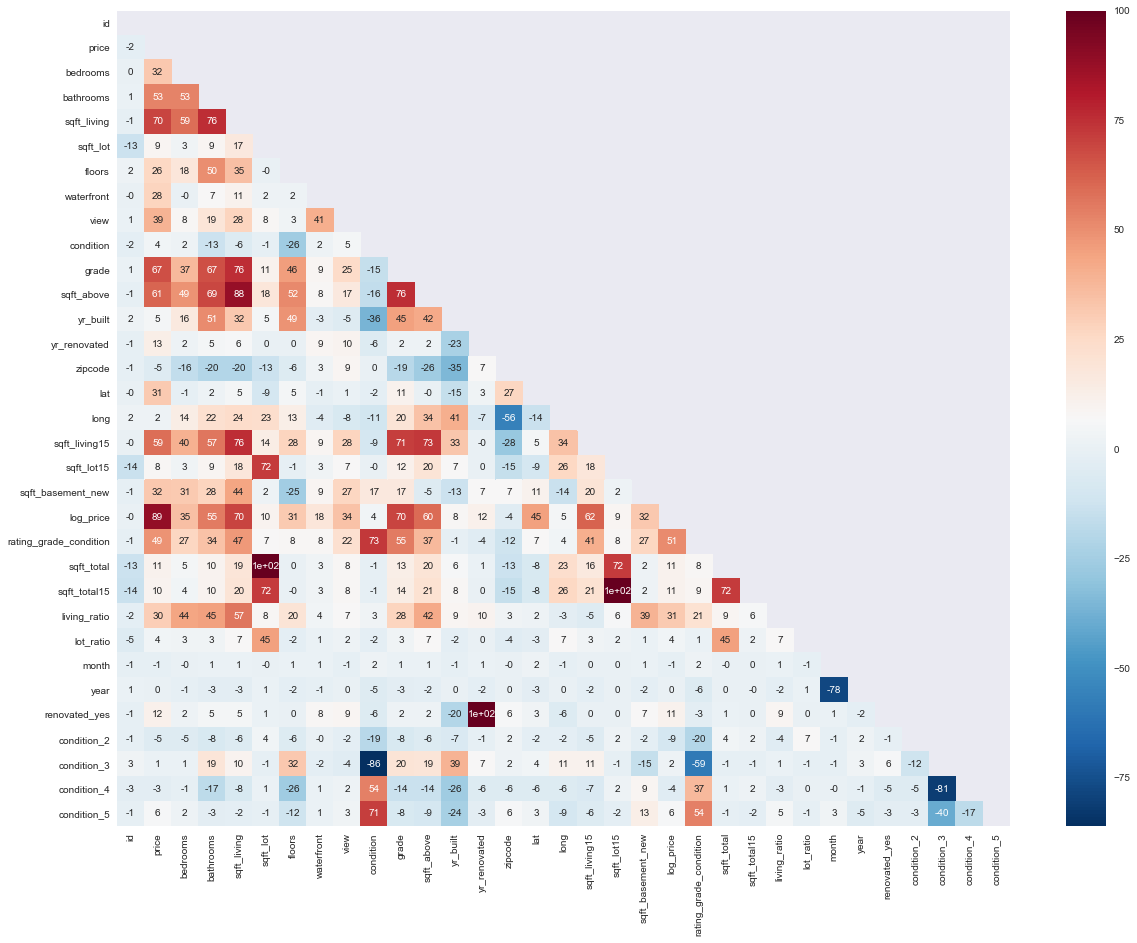

In [84]:
mask = np.triu(house_prices.corr())
plt.figure(figsize = (20,15))
ax = sns.heatmap(round(house_prices.corr()*100)
                 ,annot=True
                 ,mask=mask
                 ,cmap='RdBu_r')


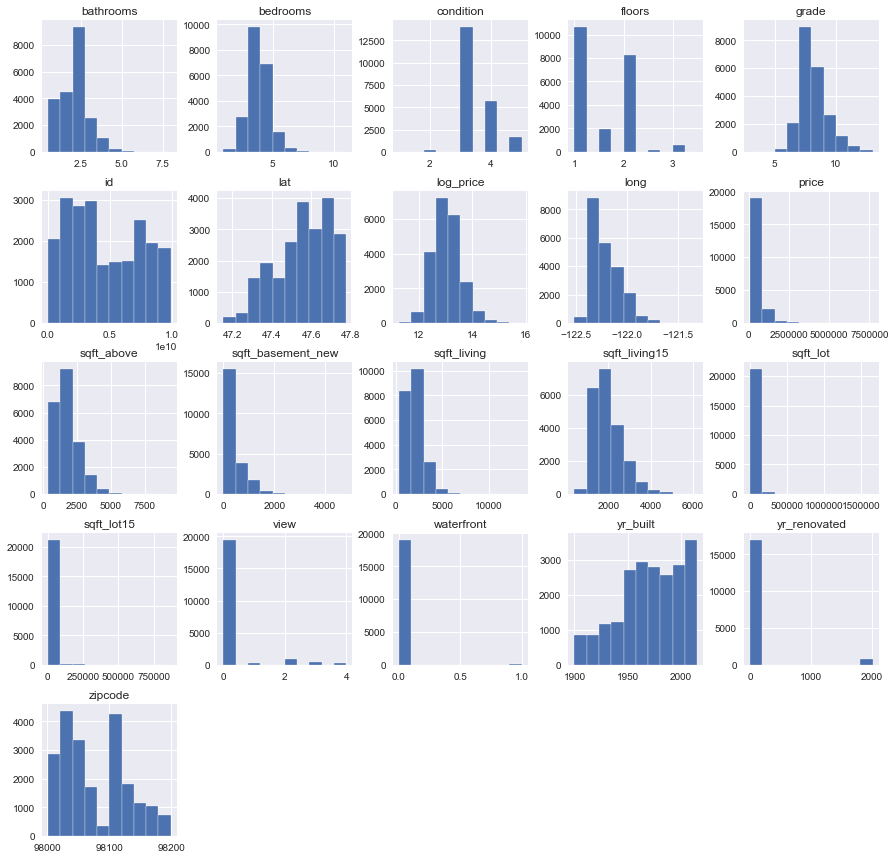

In [22]:
_ = house_prices.hist(figsize=(15,15))

**Correlation between the Price and Square footage of the apartments interior living space**

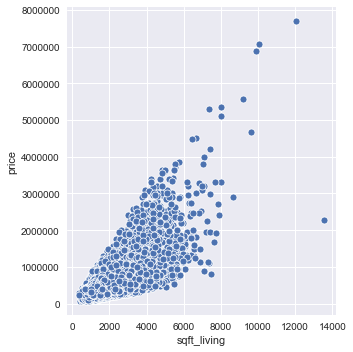

In [23]:
sns.relplot(y="price", x="sqft_living", data=house_prices);

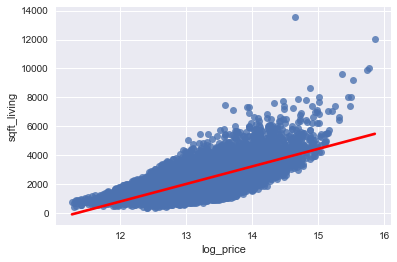

In [91]:
sns.regplot(x="log_price", y="sqft_living", line_kws= {'color' : 'red'}, data=house_prices);

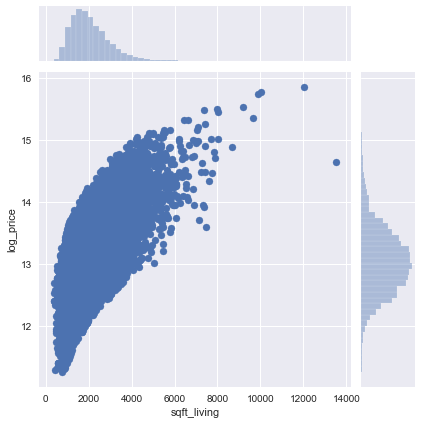

In [24]:
sns.jointplot(y="log_price", x="sqft_living", data=house_prices);

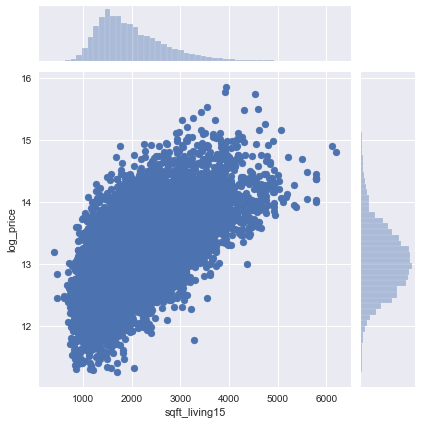

In [25]:
sns.jointplot(y="log_price", x="sqft_living15", data=house_prices);

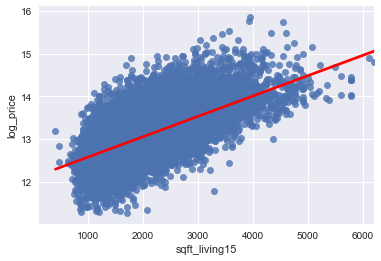

In [93]:
sns.regplot(x="sqft_living15", y="log_price", line_kws= {'color' : 'red'}, data=house_prices);

**Correlation between the Price and Square footage of the land space**

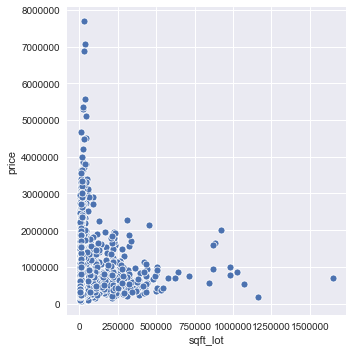

In [26]:
sns.relplot(y="price", x="sqft_lot", data=house_prices);

**Correlation between the Price and grade - An index from 1 to 13, where 1-3 falls short of building construction and design, 7 has an average level of construction and design, and 11-13 have a high quality level of construction and design.**

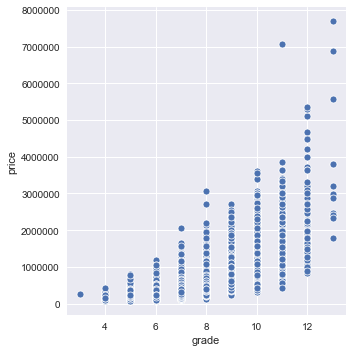

In [27]:
sns.relplot(y="price", x="grade", data=house_prices);

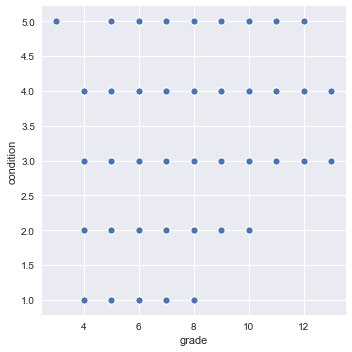

In [28]:
sns.relplot(y="condition", x="grade", data=house_prices);

In [29]:
house_prices.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 21596 entries, 0 to 21596
Data columns (total 22 columns):
id                   21596 non-null int64
date                 21596 non-null object
price                21596 non-null float64
bedrooms             21596 non-null int64
bathrooms            21596 non-null float64
sqft_living          21596 non-null int64
sqft_lot             21596 non-null int64
floors               21596 non-null float64
waterfront           19220 non-null float64
view                 21596 non-null float64
condition            21596 non-null int64
grade                21596 non-null int64
sqft_above           21596 non-null int64
yr_built             21596 non-null int64
yr_renovated         17754 non-null float64
zipcode              21596 non-null int64
lat                  21596 non-null float64
long                 21596 non-null float64
sqft_living15        21596 non-null int64
sqft_lot15           21596 non-null int64
sqft_basement_new    21596 non-nul

## Feature Engineering
### Creating Variables

New rating to get one variable out of Grade and Condiition of the houses.

In [30]:
house_prices.eval('rating_grade_condition = grade * condition', inplace=True)

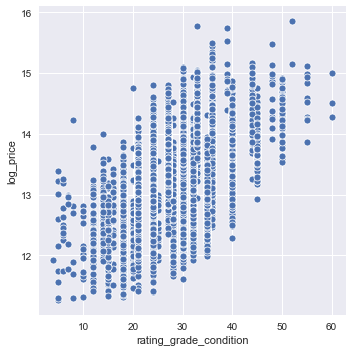

In [31]:
sns.relplot(y="log_price", x="rating_grade_condition", data=house_prices);

**Total square footage of the sold houses:** sqft_total = sqft_living + sqft_lot

In [32]:
house_prices.eval('sqft_total = sqft_living + sqft_lot', inplace=True)

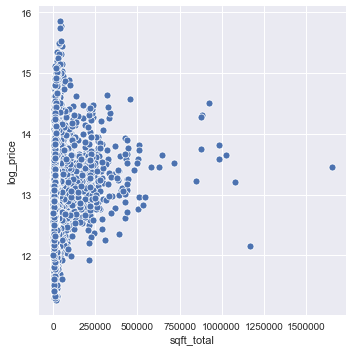

In [33]:
sns.relplot(y="log_price", x="sqft_total", data=house_prices);

**Total square footage for the nearest 15 neighbors:** sqft_total15 = sqft_living_15 + sqft_lot_15

In [34]:
house_prices.eval('sqft_total15 = sqft_living15 + sqft_lot15', inplace=True)

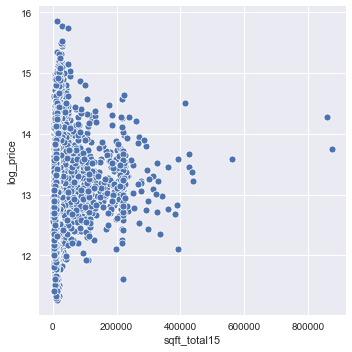

In [35]:
sns.relplot(y="log_price", x="sqft_total15", data=house_prices);

**Creating a ratio between sqft_living15 and sqft_living and sqft_lot and sqft_lot15**

In [36]:
house_prices.eval('living_ratio = sqft_living / sqft_living15', inplace=True)

In [37]:
house_prices.eval('lot_ratio = sqft_lot / sqft_lot15', inplace=True)

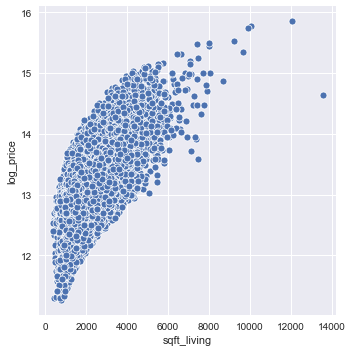

In [38]:
sns.relplot(y="log_price", x="sqft_living", data=house_prices);

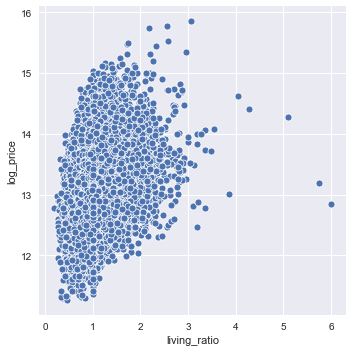

In [39]:
sns.relplot(y="log_price", x="living_ratio", data=house_prices);

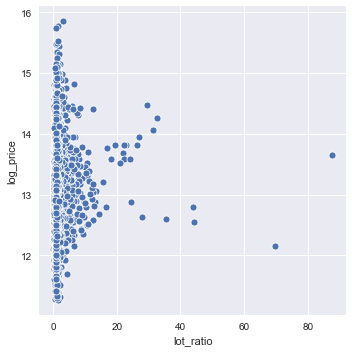

In [40]:
sns.relplot(y="log_price", x="lot_ratio", data=house_prices);

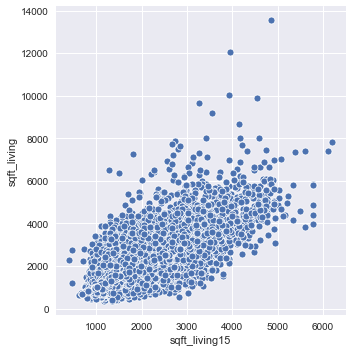

In [41]:
sns.relplot(y="sqft_living", x="sqft_living15", data=house_prices);

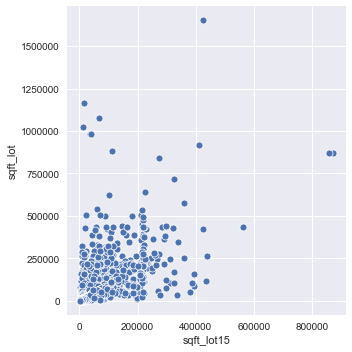

In [42]:
sns.relplot(y="sqft_lot", x="sqft_lot15", data=house_prices);

**Creating new columns "Month" and "Year" for the Date of sale**

In [43]:
house_prices['month'] = [int(x.split('/')[0]) for x in house_prices.date]

In [44]:
house_prices['year'] = [int(x.split('/')[2]) for x in house_prices.date]


In [45]:
house_prices.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  sqft_lot15  sqft_basement_new  \
0      5650     1.0         NaN   0.0  ...        5650                  0   
1      7242     2.0         0.0   0.0  ...        7639                400   
2     10000     1.0         0.0   0.0  ...        8062                  0   
3      5000     1.0         0.0   0.0  ...        5000                910   
4      8080     1.0         0.0   0.0  ...        7503                  0   

   log_price  rating_grade_condition  sqft_total  sqft_total15  living_ratio  \
0  12.309982                      21        6830          6990      0.880597   
1  13.195614                      21        9812          9329      1.520710   
2  12.100712                      18       10770         10782      0.283088   
3  13.311329                      35        6960          6360      1.441176   
4  13.142166                      24        9760          9303      0.933333   

   lot_ratio  month  year  
0   1.000000     10  2014  
1   0.948030     12  2014  
2   1.240387      2  2015  
3   1.000000     12  2014  
4   1.076903      2  2015  

[5 rows x 29 columns]

**Creating new column dummy variable for renovation: yes or no**

In [46]:
str(house_prices.yr_renovated[2])

'nan'

In [47]:
reno_yes = [0 if str(yr) == 'nan' or yr == 0.0 else 1 for yr in house_prices.yr_renovated ]
reno_no =  [1 if str(yr) == 'nan' or yr == 0.0 else 0 for yr in house_prices.yr_renovated ]
house_prices['renovated_yes'] = reno_yes


**Getting dummie variables for condition:**

In [48]:
condition_dummies = pd.get_dummies(house_prices['condition'], prefix='condition', drop_first=True)

In [49]:
house_prices = pd.concat([house_prices, condition_dummies], axis=1)

In [105]:
house_prices.head(2)

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   

   sqft_lot  floors  waterfront  view  ...  sqft_total15  living_ratio  \
0      5650     1.0         NaN   0.0  ...          6990      0.880597   
1      7242     2.0         0.0   0.0  ...          9329      1.520710   

   lot_ratio  month  year  renovated_yes  condition_2  condition_3  \
0    1.00000     10  2014              0            0            1   
1    0.94803     12  2014              1            0            1   

   condition_4  condition_5  
0            0            0  
1            0            0  

[2 rows x 34 columns]

## Predictive Modeling

### Modeling with Statsmodel

In [106]:
lab_lst = [x for x in house_prices.columns]
lab_lst.remove('id')
lab_lst.remove('yr_renovated')
lab_lst.remove('waterfront')
lab_lst.remove('date')
lab_lst.remove('price')
lab_lst.remove('log_price')
lab_lst.remove('condition')


lab_lst

['bedrooms',
 'bathrooms',
 'sqft_living',
 'sqft_lot',
 'floors',
 'view',
 'grade',
 'sqft_above',
 'yr_built',
 'zipcode',
 'lat',
 'long',
 'sqft_living15',
 'sqft_lot15',
 'sqft_basement_new',
 'rating_grade_condition',
 'sqft_total',
 'sqft_total15',
 'living_ratio',
 'lot_ratio',
 'month',
 'year',
 'renovated_yes',
 'condition_2',
 'condition_3',
 'condition_4',
 'condition_5']

In [107]:
X = house_prices[lab_lst]
X = sms.add_constant(X)
y = house_prices.log_price


/Users/eikerogall/opt/anaconda3/envs/nf/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2389: FutureWarning:

Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.



In [108]:
sms.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.771
Model:                            OLS   Adj. R-squared:                  0.771
Method:                 Least Squares   F-statistic:                     3032.
Date:                Thu, 11 Jun 2020   Prob (F-statistic):               0.00
Time:                        09:29:48   Log-Likelihood:                -859.03
No. Observations:               21596   AIC:                             1768.
Df Residuals:                   21571   BIC:                             1968.
Df Model:                          24                                         
Covariance Type:            nonrobust                                         
==========================================================================================
                             coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   -130.9827     12.473    -10.501      0.000    -155.431    -106.534
bedrooms                  -0.0219      0.003     -8.706      0.000      -0.027      -0.017
bathrooms                  0.0680      0.004     16.584      0.000       0.060       0.076
sqft_living              3.18e-05    4.2e-06      7.566      0.000    2.36e-05       4e-05
sqft_lot               -1.564e-05    2.1e-06     -7.435      0.000   -1.98e-05   -1.15e-05
floors                     0.0738      0.005     16.308      0.000       0.065       0.083
view                       0.0774      0.002     31.114      0.000       0.073       0.082
grade                      0.1233      0.009     13.984      0.000       0.106       0.141
sqft_above              1.127e-05   3.26e-06      3.455      0.001    4.87e-06    1.77e-05
yr_built                  -0.0035   9.12e-05    -38.124      0.000      -0.004      -0.003
zipcode                   -0.0007   4.15e-05    -16.414      0.000      -0.001      -0.001
lat                        1.3967      0.013    103.776      0.000       1.370       1.423
long                      -0.1636      0.016     -9.921      0.000      -0.196      -0.131
sqft_living15              0.0001   6.15e-06     20.609      0.000       0.000       0.000
sqft_lot15             -6.358e-05   3.08e-06    -20.644      0.000   -6.96e-05   -5.75e-05
sqft_basement_new       2.054e-05   3.64e-06      5.643      0.000    1.34e-05    2.77e-05
rating_grade_condition     0.0102      0.002      4.088      0.000       0.005       0.015
sqft_total              1.616e-05    2.1e-06      7.694      0.000     1.2e-05    2.03e-05
sqft_total15            6.322e-05   3.07e-06     20.568      0.000    5.72e-05    6.92e-05
living_ratio               0.1801      0.015     11.645      0.000       0.150       0.210
lot_ratio                 -0.0024      0.002     -1.386      0.166      -0.006       0.001
month                      0.0025      0.001      2.796      0.005       0.001       0.004
year                       0.0641      0.006     10.851      0.000       0.052       0.076
renovated_yes              0.0803      0.010      8.055      0.000       0.061       0.100
condition_2                0.0334      0.052      0.639      0.523      -0.069       0.136
condition_3                0.0959      0.055      1.747      0.081      -0.012       0.204
condition_4                0.0763      0.066      1.149      0.251      -0.054       0.207
condition_5                0.0723      0.080      0.900      0.368      -0.085       0.230
==============================================================================
Omnibus:                      333.316   Durbin-Watson:                   1.987
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              651.740
Skew:                    

Due to bad p-values, the columns: condition, sqft_above, month, rating_grade_condition will be removed:

In [109]:

lab_lst.remove('sqft_above')
lab_lst.remove('month')
lab_lst.remove('rating_grade_condition')
lab_lst.remove('condition_2')
lab_lst.remove('condition_3')
lab_lst.remove('condition_4')
lab_lst.remove('condition_5')

In [110]:
X = house_prices[lab_lst]
X = sms.add_constant(X)
y = house_prices.log_price
sms.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.766
Model:                            OLS   Adj. R-squared:                  0.766
Method:                 Least Squares   F-statistic:                     3923.
Date:                Thu, 11 Jun 2020   Prob (F-statistic):               0.00
Time:                        09:29:50   Log-Likelihood:                -1109.5
No. Observations:               21596   AIC:                             2257.
Df Residuals:                   21577   BIC:                             2409.
Df Model:                          18                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
const               -85.5136      8.312    -10.287      0.000    -101.807     -69.221
bedrooms             -0.0200      0.003     -7.892      0.000      -0.025      -0.015
bathrooms             0.0738      0.004     17.843      0.000       0.066       0.082
sqft_living        3.376e-05   5.75e-06      5.869      0.000    2.25e-05     4.5e-05
sqft_lot          -1.661e-05   2.88e-06     -5.773      0.000   -2.23e-05    -1.1e-05
floors                0.0690      0.005     15.140      0.000       0.060       0.078
view                  0.0787      0.003     31.304      0.000       0.074       0.084
grade                 0.1591      0.003     58.103      0.000       0.154       0.164
yr_built             -0.0041   8.65e-05    -47.050      0.000      -0.004      -0.004
zipcode              -0.0008   4.15e-05    -18.602      0.000      -0.001      -0.001
lat                   1.3830      0.014    101.828      0.000       1.356       1.410
long                 -0.1634      0.017     -9.809      0.000      -0.196      -0.131
sqft_living15         0.0001   6.22e-06     20.640      0.000       0.000       0.000
sqft_lot15        -6.453e-05   3.11e-06    -20.721      0.000   -7.06e-05   -5.84e-05
sqft_basement_new  2.062e-05    5.5e-06      3.746      0.000    9.83e-06    3.14e-05
sqft_total         1.716e-05   2.88e-06      5.968      0.000    1.15e-05    2.28e-05
sqft_total15       6.414e-05   3.11e-06     20.640      0.000     5.8e-05    7.02e-05
living_ratio          0.1910      0.016     12.220      0.000       0.160       0.222
lot_ratio            -0.0041      0.002     -2.337      0.019      -0.008      -0.001
year                  0.0469      0.004     12.628      0.000       0.040       0.054
renovated_yes         0.0483      0.010      4.867      0.000       0.029       0.068
==============================================================================
Omnibus:                      382.114   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              746.364
Skew:                          -0.081   Prob(JB):                    8.50e-163
Kurtosis:                       3.896   Cond. No.                     1.58e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 9.66e-19. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Due to bad p-value or small t-values, the columns: sqft_lot, sqft_basement_new, sqft_total will be removed:

In [111]:
lab_lst.remove('sqft_lot')
lab_lst.remove('sqft_basement_new')
lab_lst.remove('sqft_total')

In [112]:
X = house_prices[lab_lst]
X = sms.add_constant(X)
y = house_prices.log_price
sms.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.765
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     4397.
Date:                Thu, 11 Jun 2020   Prob (F-statistic):               0.00
Time:                        09:29:52   Log-Likelihood:                -1141.0
No. Observations:               21596   AIC:                             2316.
Df Residuals:                   21579   BIC:                             2452.
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -86.8750      8.314    -10.449      0.000    -103.171     -70.579
bedrooms         -0.0201      0.003     -7.893      0.000      -0.025      -0.015
bathrooms         0.0763      0.004     18.678      0.000       0.068       0.084
sqft_living    5.904e-05   8.45e-06      6.986      0.000    4.25e-05    7.56e-05
floors            0.0616      0.004     15.126      0.000       0.054       0.070
view              0.0807      0.002     32.500      0.000       0.076       0.086
grade             0.1582      0.003     58.275      0.000       0.153       0.164
yr_built         -0.0041   8.67e-05    -47.086      0.000      -0.004      -0.004
zipcode          -0.0008   4.16e-05    -18.474      0.000      -0.001      -0.001
lat               1.3867      0.014    102.622      0.000       1.360       1.413
long             -0.1698      0.016    -10.338      0.000      -0.202      -0.138
sqft_living15     0.0001   6.21e-06     20.170      0.000       0.000       0.000
sqft_lot15    -6.278e-05   3.11e-06    -20.187      0.000   -6.89e-05   -5.67e-05
sqft_total15   6.296e-05   3.11e-06     20.266      0.000    5.69e-05    6.91e-05
living_ratio      0.1894      0.016     12.106      0.000       0.159       0.220
lot_ratio         0.0034      0.001      2.464      0.014       0.001       0.006
year              0.0469      0.004     12.612      0.000       0.040       0.054
renovated_yes     0.0483      0.010      4.852      0.000       0.029       0.068
==============================================================================
Omnibus:                      373.803   Durbin-Watson:                   1.985
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              722.589
Skew:                          -0.081   Prob(JB):                    1.24e-157
Kurtosis:                       3.881   Cond. No.                     1.73e+16
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 7.3e-19. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

Removing more features to achieve better predicitions:

In [113]:
lab_lst.remove('bedrooms')
lab_lst.remove('view')

lab_lst.remove('year')

In [114]:
lab_lst.remove('zipcode')
lab_lst.remove('long')
lab_lst.remove('floors')
lab_lst.remove('sqft_total15')
lab_lst.remove('sqft_lot15')
lab_lst.remove('lot_ratio')

In [115]:
lab_lst.remove('living_ratio')

In [116]:
X = house_prices[lab_lst]
X = sms.add_constant(X)
y = house_prices.log_price
sms.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:              log_price   R-squared:                       0.745
Model:                            OLS   Adj. R-squared:                  0.745
Method:                 Least Squares   F-statistic:                     9001.
Date:                Thu, 11 Jun 2020   Prob (F-statistic):               0.00
Time:                        09:29:55   Log-Likelihood:                -2044.4
No. Observations:               21596   AIC:                             4105.
Df Residuals:                   21588   BIC:                             4169.
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           -43.5827      0.692    -62.986      0.000     -44.939     -42.226
bathrooms         0.0907      0.004     22.420      0.000       0.083       0.099
sqft_living       0.0001   4.11e-06     34.354      0.000       0.000       0.000
grade             0.1775      0.003     65.410      0.000       0.172       0.183
yr_built         -0.0041   7.98e-05    -51.404      0.000      -0.004      -0.004
lat               1.3176      0.014     97.279      0.000       1.291       1.344
sqft_living15     0.0001   4.29e-06     23.834      0.000    9.39e-05       0.000
renovated_yes     0.0740      0.010      7.171      0.000       0.054       0.094
==============================================================================
Omnibus:                      409.895   Durbin-Watson:                   1.976
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              844.156
Skew:                           0.063   Prob(JB):                    4.94e-184
Kurtosis:                       3.960   Cond. No.                     1.38e+06
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.38e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

**The best features with the highest impact on predicting the price seems to be:**
- **bathrooms**
- **sqft_living**
- **grade**
- **lat**
- **yr_built**
- **sqft_living15**
- **reno_yes**
- **reno_no**


### Modeling with Sklearn


#### Splitting data in Train- and Testsets

In [117]:
X = house_prices[['bathrooms', 'sqft_living15', 'sqft_living', 'grade', 'lat', 'yr_built']]

y = house_prices.log_price


In [118]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42, shuffle=False)
print('X_Train:', X_train.shape[0],'X_Test:', X_test.shape[0])
print('y_Train:', y_train.shape[0],'y_Test:', y_test.shape[0])

X_Train: 14469 X_Test: 7127
y_Train: 14469 y_Test: 7127


#### Modeling

In [119]:
model_sk = LinearRegression()
model_sk.fit(X_train,y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [120]:
model_sk.score(X_train,y_train)

0.7421663301300225

In [121]:
y_price_pred = model_sk.predict(X_test)
y_price_pred

array([13.4221603 , 12.66586009, 12.66586009, ..., 12.3908268 ,
       12.80447415, 12.3952189 ])

In [122]:
# The coefficients
print('Coefficients: \n', model_sk.coef_)
# Root mean squared error
print('Root Mean squared error (RMSE): %.2f'
      % mean_squared_error(y_price_pred, y_test, squared = False))
# r**2: 1 is perfect prediction
print('R**2: %.2f'
      % r2_score(y_test, y_price_pred))

Coefficients: 
 [ 9.51610728e-02  1.26855199e-04  1.36004032e-04  1.71962290e-01
  1.28704033e+00 -4.77820440e-03]
Root Mean squared error (RMSE): 0.27
R**2: 0.74


#### House for Four

The ideal house for four persons should of a square footage of 2200 or more (Source: mentioned above), the price should be under the median value of the neighbourhood and nevertheless should have around the same footage and a decent rating. Owning a house equal to +/- 25% 2,422 square feet, the median size house as of 2016 gives you a typical middle class house size.

In [123]:
X_train.head()

bathrooms  sqft_living15  sqft_living  grade      lat  yr_built
0       1.00           1340         1180      7  47.5112      1955
1       2.25           1690         2570      7  47.7210      1951
2       1.00           2720          770      6  47.7379      1933
3       3.00           1360         1960      7  47.5208      1965
4       2.00           1800         1680      8  47.6168      1987

In [124]:
X_train.describe().round()

bathrooms  sqft_living15  sqft_living    grade      lat  yr_built
count    14469.0        14469.0      14469.0  14469.0  14469.0   14469.0
mean         2.0         1972.0       2049.0      8.0     48.0    1967.0
std          1.0          673.0        905.0      1.0      0.0      28.0
min          0.0          399.0        380.0      3.0     47.0    1900.0
25%          2.0         1480.0       1410.0      7.0     47.0    1950.0
50%          2.0         1830.0       1890.0      7.0     48.0    1969.0
75%          2.0         2330.0       2490.0      8.0     48.0    1990.0
max          8.0         6110.0      13540.0     13.0     48.0    2015.0

In [125]:
house_prices.head()

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   
2  5631500400   2/25/2015  180000.0         2       1.00          770   
3  2487200875   12/9/2014  604000.0         4       3.00         1960   
4  1954400510   2/18/2015  510000.0         3       2.00         1680   

   sqft_lot  floors  waterfront  view  ...  sqft_total15  living_ratio  \
0      5650     1.0         NaN   0.0  ...          6990      0.880597   
1      7242     2.0         0.0   0.0  ...          9329      1.520710   
2     10000     1.0         0.0   0.0  ...         10782      0.283088   
3      5000     1.0         0.0   0.0  ...          6360      1.441176   
4      8080     1.0         0.0   0.0  ...          9303      0.933333   

   lot_ratio  month  year  renovated_yes  condition_2  condition_3  \
0   1.000000     10  2014              0            0            1   
1   0.948030     12  2014              1            0            1   
2   1.240387      2  2015              0            0            1   
3   1.000000     12  2014              0            0            0   
4   1.076903      2  2015              0            0            1   

   condition_4  condition_5  
0            0            0  
1            0            0  
2            0            0  
3            0            1  
4            0            0  

[5 rows x 34 columns]

In [126]:
X_optimal = pd.DataFrame({
    'bathrooms': [2],
    'sqft_living15': [2200],
    'sqft_living': [2200],
    'grade': [7],
    'lat': [48], 
    'yr_built':[1969]
})
X_optimal

bathrooms  sqft_living15  sqft_living  grade  lat  yr_built
0          2           2200         2200      7   48      1969

In [127]:
y_optimal_pred = model_sk.predict(X_optimal)
y_optimal_pred.round(3)

array([13.533])

In [128]:
house_prices.query('log_price <= 13.533').describe()

id          price      bedrooms     bathrooms   sqft_living  \
count  1.804400e+04   18044.000000  18044.000000  18044.000000  18044.000000   
mean   4.621001e+09  422833.872368      3.262303      1.973745   1845.097151   
std    2.866249e+09  151429.101449      0.868431      0.673342    669.532195   
min    1.000102e+06   78000.000000      1.000000      0.500000    370.000000   
25%    2.159650e+09  300000.000000      3.000000      1.500000   1340.000000   
50%    3.956000e+09  406825.000000      3.000000      2.000000   1760.000000   
75%    7.338000e+09  536813.250000      4.000000      2.500000   2260.000000   
max    9.900000e+09  753888.000000     11.000000      7.500000   5774.000000   

           sqft_lot        floors    waterfront          view     condition  \
count  1.804400e+04  18044.000000  16055.000000  18044.000000  18044.000000   
mean   1.358611e+04      1.443388      0.001993      0.126579      3.401740   
std    3.629186e+04      0.535133      0.044602      0.540900      0.643126   
min    5.200000e+02      1.000000      0.000000      0.000000      1.000000   
25%    5.000000e+03      1.000000      0.000000      0.000000      3.000000   
50%    7.440000e+03      1.000000      0.000000      0.000000      3.000000   
75%    1.001800e+04      2.000000      0.000000      0.000000      4.000000   
max    1.651359e+06      3.500000      1.000000      4.000000      5.000000   

       ...   sqft_total15  living_ratio     lot_ratio         month  \
count  ...   18044.000000  18044.000000  18044.000000  18044.000000   
mean   ...   13706.707770      1.020334      1.105718      6.583906   
std    ...   24884.014827      0.290122      1.025707      3.129916   
min    ...    1721.000000      0.187279      0.054972      1.000000   
25%    ...    6780.000000      0.862745      0.934534      4.000000   
50%    ...    9254.000000      1.000000      1.000000      6.000000   
75%    ...   11514.250000      1.121705      1.080345      9.000000   
max    ...  440913.000000      6.000000     69.623072     12.000000   

               year  renovated_yes   condition_2   condition_3   condition_4  \
count  18044.000000   18044.000000  18044.000000  18044.000000  18044.000000   
mean    2014.323709       0.025549      0.009089      0.648304      0.268178   
std        0.467903       0.157789      0.094904      0.477513      0.443023   
min     2014.000000       0.000000      0.000000      0.000000      0.000000   
25%     2014.000000       0.000000      0.000000      0.000000      0.000000   
50%     2014.000000       0.000000      0.000000      1.000000      0.000000   
75%     2015.000000       0.000000      0.000000      1.000000      1.000000   
max     2015.000000       1.000000      1.000000      1.000000      1.000000   

        condition_5  
count  18044.000000  
mean       0.072877  
std        0.259942  
min        0.000000  
25%        0.000000  
50%        0.000000  
75%        0.000000  
max        1.000000  

[8 rows x 33 columns]

In the US owning a home equal to roughly 4X – 6X your household income puts you in the middle class. (Source: https://www.financialsamurai.com/the-ideal-house-size-and-layout-to-raise-a-family/) In Seattle the median income in 2015 was 80000 US-D per year and household. That make middle class houses range from 320000 to 480000 US-D. The prediction of the optimal log_price for a four person household of **13.533** that means all prices below that log price have a median of **406825.00 US-D** which lays in the range of middle class households. 

In [129]:
# for a bargin we are looking for houses under 406825 US-D and over the ideal parameters
# for a four person house hold
price_opt_four = house_prices.query('sqft_living > 2200 and bathrooms >= 2 and price < 406825 and  rating_grade_condition > 24 and bedrooms >=4')
print('Min price grouped by condition:', price_opt_four.groupby('condition')['price'].min())
price_opt_four


Min price grouped by condition: condition
3    257000.0
4    220000.0
5    265000.0
Name: price, dtype: float64


id        date     price  bedrooms  bathrooms  sqft_living  \
51     7231300125   2/17/2015  345000.0         5       2.50         3150   
86     2599001200   11/3/2014  305000.0         5       2.25         2660   
148    8075400570  10/30/2014  258000.0         5       2.00         2260   
285    1509500060    9/5/2014  370000.0         4       2.50         2720   
361    1072010350   8/28/2014  380000.0         5       2.50         2760   
373    7683900200  12/23/2014  380000.0         5       3.00         3450   
430    5468750060  10/28/2014  328500.0         4       3.00         2290   
463    4166600473   12/9/2014  359500.0         4       2.25         2390   
548    2473420140   9/23/2014  315000.0         4       2.75         2300   
561    1921069084    7/7/2014  404950.0         4       2.25         2340   
601    3211230260    2/4/2015  399950.0         4       2.00         2420   
778    7300400060   5/15/2014  370000.0         4       2.50         2710   
1006   9264960340   6/17/2014  325000.0         4       2.50         2610   
1108   5416510060    3/6/2015  367000.0         4       2.50         2960   
1111   1509500160   3/24/2015  350900.0         4       2.50         2540   
1158   1865810060   8/12/2014  267500.0         5       3.50         2390   
1167   3110800260   7/15/2014  274700.0         4       2.00         2440   
1255   3832711040   4/24/2015  321000.0         5       2.75         3030   
1287   8944460030  10/14/2014  325000.0         4       2.50         2963   
1370   3521069051  12/23/2014  330000.0         4       2.25         2380   
1505   2214800270   9/25/2014  355000.0         4       2.50         2770   
1508   4136930310   11/6/2014  360000.0         4       2.50         2390   
1619   1310500550  12/20/2014  248000.0         4       2.25         2320   
1656   1898200030   9/22/2014  335000.0         4       2.50         2240   
1739   1843100070   2/10/2015  372000.0         4       2.75         2610   
1869   1887500045  12/26/2014  247500.0         4       2.00         2460   
1980   7298020240    5/9/2014  402500.0         4       2.50         2600   
2094   1721059286   1/21/2015  383000.0         4       2.50         2640   
2195   5149300400    2/6/2015  311750.0         4       2.25         2270   
2217   2781260370   1/28/2015  398000.0         4       2.50         2820   
...           ...         ...       ...       ...        ...          ...   
18329  2944500330   8/25/2014  330000.0         4       2.50         2510   
18554  5089700300   3/11/2015  365650.0         4       2.25         2380   
18632  9485951460   6/23/2014  385000.0         4       2.75         2700   
18669  2968801130  10/27/2014  360000.0         4       2.25         2620   
18787  3621059043   5/27/2014  293000.0         4       2.50         3250   
19017  1221039066  10/17/2014  310000.0         4       2.50         3140   
19022   984200690   6/18/2014  299000.0         5       2.50         2220   
19069  8645511500   4/20/2015  352750.0         4       2.75         2270   
19173  7942601475   5/20/2014  345600.0         5       3.50         2800   
19182  8665000040   7/30/2014  360000.0         4       2.50         3200   
19236  8650100120   8/29/2014  339950.0         5       2.50         2990   
19337  1523059103   9/26/2014  390000.0         4       2.50         2570   
19340  1152700120    4/9/2015  370000.0         4       3.00         2490   
19382  9264950410    5/4/2015  369000.0         4       2.50         2550   
19539  3379200100   5/23/2014  334000.0         4       2.50         2210   
19876  2140950160   2/22/2015  390000.0         4       2.50         2610   
19921  8151600973    4/6/2015  375000.0         4       2.50         2510   
20014  3814900750   7/16/2014  399440.0         4       2.50         2311   
20226  3845101100   1/21/2015  392440.0         4       2.50         2547   
20267   662440020   2/26/2015  380000.0         4       2.50         2420   
20314  3845

In [130]:
price_opt_four[price_opt_four['price'] == 265000]

id       date     price  bedrooms  bathrooms  sqft_living  \
5820   7749500250  8/27/2014  265000.0         5       2.25         2600   
15760  8698600080  9/10/2014  265000.0         5       2.75         2920   

       sqft_lot  floors  waterfront  view  ...  sqft_total15  living_ratio  \
5820       8075     1.5         0.0   0.0  ...         11000      1.181818   
15760      5250     1.5         0.0   0.0  ...          6470      2.393443   

       lot_ratio  month  year  renovated_yes  condition_2  condition_3  \
5820    0.917614      8  2014              0            0            0   
15760   1.000000      9  2014              0            0            0   

       condition_4  condition_5  
5820             1            0  
15760            0            1  

[2 rows x 34 columns]

Those two real estates are the cheapest for the ideal four person house hold features but they are quite far from Seattle, so what are the best options for Seattle? We are looking for real estate in at latitude over 47.496564.

In [131]:
# for a bargin we are looking for houses under 406825 US-D and over the ideal parameters
# for a four person house hold and a latitude above 47.496564
price_opt_four_seattle = house_prices.query('sqft_living > 2200 and bathrooms >= 2 and price < 406825 and  rating_grade_condition > 24 and bedrooms >=4 and lat >= 47.496564 and long <= -122.2493')

print('Min price grouped by condition:', price_opt_four_seattle.groupby('condition')['price'].min())

Min price grouped by condition: condition
3    345600.0
4    312000.0
5    290000.0
Name: price, dtype: float64


In [132]:
price_opt_four_seattle

id        date     price  bedrooms  bathrooms  sqft_living  \
2266   6145601715  12/15/2014  403500.0         4       2.75         2400   
3356   9158800090    7/3/2014  400000.0         4       2.25         2230   
6380   8850000285   6/12/2014  350000.0         4       2.25         2300   
8632    923049440   7/17/2014  312000.0         5       4.00         2900   
9087   4174600331   7/17/2014  384000.0         6       3.00         2320   
10432  3438502501   7/29/2014  400000.0         5       2.50         2510   
12894  2113700360   6/27/2014  315000.0         6       4.00         3120   
13061  7129304225    1/8/2015  305000.0         4       2.25         2340   
13658  7129800063   4/20/2015  330000.0         5       2.75         2390   
14317   626049115   11/5/2014  405000.0         4       2.50         2620   
15584  3010300415   2/11/2015  383000.0         5       2.00         2280   
15619    13001795  10/14/2014  319500.0         4       2.75         2500   
16199  3812400898    9/9/2014  399950.0         5       2.00         2760   
16372  9561100080   6/20/2014  400000.0         4       2.25         2420   
17139  4027700006    4/9/2015  405000.0         4       2.50         2670   
17272  9421500130   6/16/2014  378000.0         5       2.50         2760   
17534  6885900415    1/7/2015  290000.0         4       2.75         2240   
17851   162500015  10/20/2014  362500.0         5       2.00         2330   
19173  7942601475   5/20/2014  345600.0         5       3.50         2800   
19921  8151600973    4/6/2015  375000.0         4       2.50         2510   

       sqft_lot  floors  waterfront  view  ...  sqft_total15  living_ratio  \
2266       3844     1.0         0.0   0.0  ...          4944      2.181818   
3356       7200     1.0         0.0   0.0  ...          9762      1.109453   
6380       4600     1.5         0.0   0.0  ...          4540      1.493506   
8632       9779     2.0         0.0   0.0  ...          9360      2.132353   
9087       4502     1.0         NaN   0.0  ...          6788      2.000000   
10432      7525     1.5         0.0   0.0  ...          8011      1.976378   
12894      4240     2.0         0.0   2.0  ...          5700      2.136986   
13061      5250     2.0         0.0   0.0  ...          6790      1.519481   
13658      6282     1.0         0.0   0.0  ...          6892      1.414201   
14317      8960     1.0         0.0   0.0  ...         10840      1.393617   
15584      5750     1.0         0.0   0.0  ...          7530      1.280899   
15619      5100     1.5         0.0   0.0  ...          6530      1.748252   
16199      6420     1.0         NaN   0.0  ...          8512      1.971429   
16372      7927     1.0         0.0   0.0  ...          9813      1.141509   
17139     20894     2.0         0.0   0.0  ...         18255      1.094262   
17272      8015     1.0         0.0   0.0  ...         18460      6.000000   
17534      8162     2.0         0.0   0.0  ...          9713      1.445161   
17851      8586     1.0         0.0   0.0  ...          9837      1.503226   
19173      5120     2.5         0.0   0.0  ...          6900      1.573034   
19921      7245     2.0         0.0   0.0  ...         10730      1.371585   

       lot_ratio  month  year  renovated_yes  condition_2  condition_3  \
2266    1.000000     12  2014              0            0            0   
3356    0.928793      7  2014              0            0            0   
6380    1.533333      6  2014              0            0            0   
8632    1.222375      7  2014              0            0            0   
9087    0.799929      7  2014              0            0            0   
10432   1.116303      7  2014              0            0            0   
12894   1.000000      6  2014              0            0            0   
13061   1.000000      1  2015              0            0            0   
13658   1.207612      4  2015              0            0            0   
14317   1.000000  

In [133]:
price_opt_four_seattle.query('price == 290000.0 and lat >= 47.496564')

id      date     price  bedrooms  bathrooms  sqft_living  \
17534  6885900415  1/7/2015  290000.0         4       2.75         2240   

       sqft_lot  floors  waterfront  view  ...  sqft_total15  living_ratio  \
17534      8162     2.0         0.0   0.0  ...          9713      1.445161   

       lot_ratio  month  year  renovated_yes  condition_2  condition_3  \
17534   0.999877      1  2015              0            0            0   

       condition_4  condition_5  
17534            0            1  

[1 rows x 34 columns]

#### Investment

For the Investment I will look at the same features as before but will add the features condition and reno_yes and
reno_no. To check for a real estate in bad condition that has not been renovated.


In [135]:
house_prices.head(2)

id        date     price  bedrooms  bathrooms  sqft_living  \
0  7129300520  10/13/2014  221900.0         3       1.00         1180   
1  6414100192   12/9/2014  538000.0         3       2.25         2570   

   sqft_lot  floors  waterfront  view  ...  sqft_total15  living_ratio  \
0      5650     1.0         NaN   0.0  ...          6990      0.880597   
1      7242     2.0         0.0   0.0  ...          9329      1.520710   

   lot_ratio  month  year  renovated_yes  condition_2  condition_3  \
0    1.00000     10  2014              0            0            1   
1    0.94803     12  2014              1            0            1   

   condition_4  condition_5  
0            0            0  
1            0            0  

[2 rows x 34 columns]

In [136]:
X_2 = house_prices[['bathrooms', 'sqft_living15', 'sqft_living', 'grade', 'yr_built','lat', 'condition', 'renovated_yes']]

y_2 = house_prices.log_price


In [ ]:
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.33, random_state=42, shuffle=False)
print('X_Train:', X_2_train.shape[0],'X_Test:', X_2_test.shape[0])
print('y_Train:', y_2_train.shape[0],'y_Test:', y_2_test.shape[0])

In [ ]:
model_sk_2 = LinearRegression()
model_sk_2.fit(X_2_train,y_2_train)

In [ ]:
model_sk_2.score(X_2_train,y_2_train)

In [ ]:
y_price_pred_2 = model_sk_2.predict(X_2_test)
y_price_pred_2

In [ ]:
# The coefficients
#print('Coefficients: \n', model_sk_2.coef_)
# Root mean squared error
print('Root Mean squared error (RMSE): %.2f'
      % mean_squared_error(y_price_pred_2, y_2_test, squared = False))
# r**2: 1 is perfect prediction
print('R**2: %.2f'
      % r2_score(y_2_test, y_price_pred_2))

In [ ]:
X_2.describe().round(2)

In [ ]:
X_2_optimal = pd.DataFrame({
    'bathrooms': [2],
    'sqft_living15': [2200],
    'sqft_living': [2200],
    'grade': [7],
    'lat': [48], 
    'yr_built':[1969],
    'condition':[2],
    'reno_yes':[0],
    
})
X_2_optimal

In [ ]:
y_optimal_pred_2 = model_sk_2.predict(X_2_optimal)
y_optimal_pred_2.round(3)

In [ ]:
house_prices.query('log_price <= 13.449').describe()

The predicted optimal price for a real estate with median features in a condition of 2 is a log_price of **13.449** that means all prices below that log price have a median of **397000.00 US-D**. Now we will look for cheaper real estate,  a low condition value and which has not been renovated yet.

In [ ]:
price_opt_invest = house_prices.query('sqft_living >= 2200 and price < 397000.00 and condition <= 2 and reno_yes == 0')
print(price_opt_invest.shape[0])
price_opt_invest = price_opt_invest.copy()


Checking the average house prices in an area lat ± 0.0075 and long ± 0.0075

In [ ]:
def check_avg_price(lat,long,case):
    lat_max = lat + 0.0075
    lat_min = lat - 0.0075
    long_max= long + 0.0075
    long_min= long - 0.0075
    local_price = house_prices[(house_prices['lat'] <= lat_max) & (house_prices['lat'] >= lat_min) \
                 & (house_prices['long'] <=long_max) & (house_prices['long'] >= long_min)]
    if case == 1:
        return local_price.price.sum() / local_price.shape[0]
    if case == 2:
        return local_price.shape[0]

In [ ]:
avg_prices = []
number_of_houses = []
for lat, long in zip(price_opt_invest.lat, price_opt_invest.long):
    avg_prices.append(check_avg_price(lat,long,1))
    number_of_houses.append(check_avg_price(lat,long,2))


In [ ]:
avg_prices

In [ ]:
number_of_houses
price_opt_invest['number_of_houses_area'] = number_of_houses

In [ ]:
price_opt_invest['avg_price_area'] = avg_prices

price_opt_invest

In [ ]:
price_diff = [avg_pr-pr_ac for pr_ac, avg_pr in zip(price_opt_invest.price, price_opt_invest.avg_price_area)]
price_diff

In [ ]:
price_opt_invest['price_diff'] = price_diff
price_opt_invest.price_diff.max()

In [ ]:
price_opt_invest.query('price_diff == 108277.77777777775')


In [ ]:


def lat_long_calc(lat,long):
    lat_max = lat + 0.0075
    lat_min = lat - 0.0075
    lat_lst = [lat_max,lat_max,lat_min,lat_min,lat_max]
    long_max= long + 0.0075
    long_min= long - 0.0075
    long_lst = [long_min,long_max,long_max, long_min,long_min ]
    return lat_lst, long_lst


In [ ]:
lat_long_calc(47.3043,-122.094)


## Data Visualization

**Map scatter plot for houses above 2200 squarefeet, 2 or more bathrooms, a Price below 406825.00 US-D, more than 4 bedrooms and a rating above 24:** The bigger the circles the more expensive the house and a color scale for the product of condition and grade - An index from 25 (red) to 45 (green) on the product of condition and grade of the apartment,5 - lowest, 60 - highest

In [ ]:
fig = px.scatter_mapbox(price_opt_four.query('sqft_living > 2200 and bathrooms >= 2 and price < 406825.00 and rating_grade_condition > 24 and bedrooms >= 4')
                        ,
                        lat="lat",
                        lon="long",
                        hover_name="id",
                        hover_data=["price", "sqft_living", "zipcode", 'floors'],
                        size='price',
                        color='rating_grade_condition',
                        color_continuous_scale=['yellow', 'green'],
                        color_discrete_sequence=["fuchsia"],
                        zoom=7,
                        height=400)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
#fig.write_html("html_fig/map_for_four_1.html")   #saved as html in html_fig 
fig.show()

**Same map scatter plot as above for the two cheapest real estates with the right features**

In [ ]:
fig = px.scatter_mapbox(price_opt_four.query(
    'sqft_living > 2200 and bathrooms >= 2 and price == 265000 and rating_grade_condition > 24 and bedrooms >= 4'
),
                        lat="lat",
                        lon="long",
                        hover_name="id",
                        hover_data=["price", "sqft_living", "grade", "condition"],
                        size='price',
                        color='rating_grade_condition',
                        color_continuous_scale=['yellow','green'],
                        color_discrete_sequence=["fuchsia"],
                        zoom=7,
                        height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.write_html("html_fig/map_for_four_2.html")   #saved as html in html_fig 
fig.show()

**Those two real estates are the cheapest for the ideal four person house hold features but the are quite far from Seattle, so what are the best options for Seattle?**

In [ ]:
fig = px.scatter_mapbox(price_opt_four_seattle.query('sqft_living > 2200 and bathrooms >= 2 and price < 406825.00 and rating_grade_condition > 24 and bedrooms >= 4')
                        ,
                        lat="lat",
                        lon="long",
                        hover_name="id",
                        hover_data=["price", "sqft_living", "zipcode"],
                        size='price',
                        color='rating_grade_condition',
                        color_continuous_scale=['yellow', 'green'],
                        color_discrete_sequence=["fuchsia"],
                        zoom=7,
                        height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.write_html("html_fig/map_for_four_1.html")   #saved as html in html_fig 
fig.show()

In [ ]:
fig = px.scatter_mapbox(price_opt_four_seattle.query(
    'sqft_living > 2200 and bathrooms >= 2 and price == 290000 and rating_grade_condition > 24 and bedrooms >= 4 and lat >= 47.49'
),
                        lat="lat",
                        lon="long",
                        hover_name="id",
                        hover_data=["price", "sqft_living", "grade", "condition"],
                        size='price',
                        color='rating_grade_condition',
                        color_continuous_scale=['yellow', 'green'],
                        color_discrete_sequence=["fuchsia"],
                        zoom=7,
                        height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.write_html("html_fig/map_for_four_2.html")   #saved as html in html_fig 
fig.show()

**Map scatter plot for houses above 2200 squarefeet, a price below 440339.47 US-D and a price_ratio_15 below 1:** the bigger the circles the more expensive the house and a color scale for the condition - An index from 1 (red) to 5 (green) on the condition of the apartment,1 - lowest, 5 - highest

In [ ]:
fig = px.scatter_mapbox(price_opt_invest,
                        lat="lat",
                        lon="long",
                        hover_name="id",
                        hover_data=["price", "condition"],
                        size='price',
                        color='condition',
                        color_continuous_scale=['red', 'yellow', 'green'],
                        color_discrete_sequence=["fuchsia"],
                        zoom=7,
                        height=300)
fig.update_layout(mapbox_style="open-street-map")
fig.update_layout(margin={"r": 0, "t": 0, "l": 0, "b": 0})
fig.write_html("html_fig/map_for_invest_1.html")   #saved as html in html_fig 
fig.show()

**Same map scatter plot as above for the three cheapest real estates with the right features**

In [ ]:
site_lat = price_opt_invest.lat
site_lon = price_opt_invest.long
locations_name = price_opt_invest.price

fig = go.Figure(go.Scattermapbox(
    mode = "markers+lines",
    lon = [-122.10149999999999, -122.0865, -122.0865, -122.10149999999999, -122.10149999999999],
    lat = [47.3118, 47.3118, 47.2968, 47.2968, 47.3118],
    marker = {'size': 10}))

fig.add_trace(go.Scattermapbox(
        lat=site_lat,
        lon=site_lon,
        mode='markers',
        marker=go.scattermapbox.Marker(
            size=17,
            color='rgb(255, 0, 0)',
            opacity=0.7
        ),
        text=locations_name,
        hoverinfo='text'
    ))

fig.update_layout(
    margin ={'l':0,'t':0,'b':0,'r':0},
    mapbox = {
        'center': dict(lat=47.53, lon=-122.23),
        'style': "open-street-map",
        'center': dict(lat=47.53, lon=-122.23),
        'zoom': 9})

fig.show()

**Density Mapbox for House Prices**

In [ ]:
fig = px.density_mapbox(house_prices,
                        lat='lat',
                        lon='long',
                        z='price',
                        radius=5,
                        color_continuous_scale="electric" ,
                        center=dict(lat=47.53, lon=-122.23),
                        zoom=7,
                        mapbox_style="open-street-map")
fig.write_html("figures/map_price.html")
fig.show()